In [30]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from helper.system import Hamiltonian
from joblib import Parallel, delayed

In [31]:
# SNAIL parameters from Ben's kerr-terms comparison notebook
M = 3              # number of large JJs in a SNAIL
EJ = 90            # junction energy of larger JJ (GHz, system.py multiplies by 2*pi)
EC = 177e-3        # charging energy of the SNAIL (GHz)
beta = 0.147       # ratio between small and large JJ

# Cavity parameters (placeholder values, not the focus here)
omega_c1 = 8.045    # cavity 1 frequency (GHz)
omega_c2 = 5.0     # cavity 2 frequency (GHz)

# Hilbert space dimensions
bare_dim = [10, 1, 5]    # [SNAIL, cavity2, cavity1]
trunc_dim = [5, 1, 3]

In [32]:
# Sweep external flux and compute SNAIL frequency, g3, dressed cavity frequency, chi, K
phi_ext_list = np.linspace(0.0, 0.5, 101)

def get_all_properties(phi_ex):
    sc = Hamiltonian(phi_ex, EJ, EC, bare_dim, trunc_dim, omega_c1, omega_c2, N=M, beta=beta)
    Hs, _ = sc.SNAIL()
    Hd = sc.H_dressed
    dim = sc.original_dim

    snail_freq = float(np.real(Hs[1, 1])) / (2 * np.pi)          # GHz
    g3_val = float(np.real(sc.g3())) / (2 * np.pi)                # GHz

    pos_c = sc.state_index((0, 0, 1), dim)
    cav_freq = float(np.real(Hd[pos_c, pos_c])) / (2 * np.pi)     # GHz
    chi = sc.chi() / (2 * np.pi)                                    # GHz
    K = sc.anharmonicity() / (2 * np.pi)                            # GHz

    return snail_freq, g3_val, cav_freq, chi, K

results = Parallel(n_jobs=-1)(delayed(get_all_properties)(phi) for phi in phi_ext_list)
snail_freqs = np.array([r[0] for r in results])
g3_values = np.array([r[1] for r in results])
cavity_freqs = np.array([r[2] for r in results])
chi_values = np.array([r[3] for r in results])
K_values = np.array([r[4] for r in results])

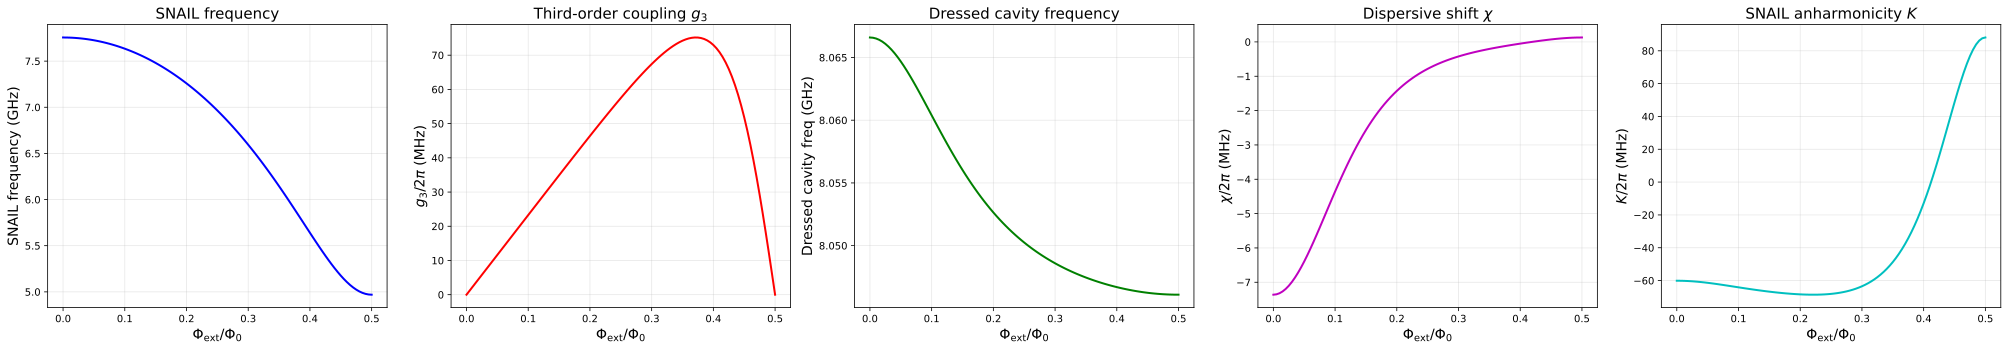

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(28, 5))
xlabel = r'$\Phi_{\rm ext} / \Phi_0$'

# (a) SNAIL frequency
axes[0].plot(phi_ext_list, snail_freqs, 'b-', linewidth=2)
axes[0].set_xlabel(xlabel, fontsize=14)
axes[0].set_ylabel('SNAIL frequency (GHz)', fontsize=14)
axes[0].set_title('SNAIL frequency', fontsize=15)
axes[0].grid(True, alpha=0.3)

# (b) g3
axes[1].plot(phi_ext_list, g3_values * 1e3, 'r-', linewidth=2)
axes[1].set_xlabel(xlabel, fontsize=14)
axes[1].set_ylabel(r'$g_3 / 2\pi$ (MHz)', fontsize=14)
axes[1].set_title(r'Third-order coupling $g_3$', fontsize=15)
axes[1].grid(True, alpha=0.3)

# (c) Dressed cavity frequency
axes[2].plot(phi_ext_list, cavity_freqs, 'g-', linewidth=2)
axes[2].set_xlabel(xlabel, fontsize=14)
axes[2].set_ylabel('Dressed cavity freq (GHz)', fontsize=14)
axes[2].set_title('Dressed cavity frequency', fontsize=15)
axes[2].grid(True, alpha=0.3)

# (d) Dispersive shift chi
axes[3].plot(phi_ext_list, chi_values * 1e3, 'm-', linewidth=2)
axes[3].set_xlabel(xlabel, fontsize=14)
axes[3].set_ylabel(r'$\chi / 2\pi$ (MHz)', fontsize=14)
axes[3].set_title(r'Dispersive shift $\chi$', fontsize=15)
axes[3].grid(True, alpha=0.3)

# (e) SNAIL anharmonicity K
axes[4].plot(phi_ext_list, K_values * 1e3, 'c-', linewidth=2)
axes[4].set_xlabel(xlabel, fontsize=14)
axes[4].set_ylabel(r'$K / 2\pi$ (MHz)', fontsize=14)
axes[4].set_title(r'SNAIL anharmonicity $K$', fontsize=15)
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [52]:
# Quasi-energy sweep: fix drive frequency and amplitude, sweep flux
omega_d = 6.5 * 2 * np.pi    # drive frequency (rad * GHz)
A_d = 3e-3 * 2 * np.pi       # drive amplitude (rad * GHz)

phi_ext_qe = np.linspace(0.311, 0.315, 51)

def get_quasi_energy(phi_ex):
    sc = Hamiltonian(phi_ex, EJ, EC, bare_dim, trunc_dim, omega_c1, omega_c2, N=M, beta=beta)
    eq1, eq2, eq3 = sc.quasi_energy(A_d, omega_d)
    # eq1 = cavity (0,0,1), eq2 = (0,0,2) or next state, eq3 = SNAIL (1,0,0)
    return float(np.real(eq1)) / (2 * np.pi)  # cavity quasi-energy in GHz

qe_cavity = Parallel(n_jobs=-1)(delayed(get_quasi_energy)(phi) for phi in phi_ext_qe)
qe_cavity = np.array(qe_cavity)

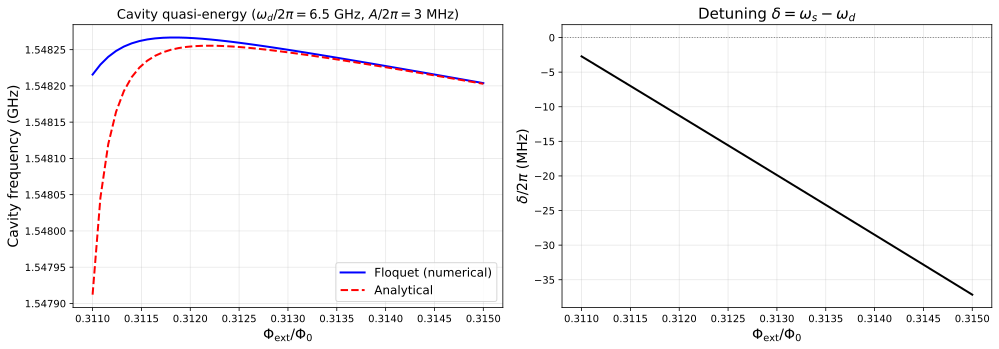

In [55]:
# Compute analytical cavity frequency for comparison
# omega_c = omega_c_bar + A^2/delta - A^2/(delta + chi)
# where delta = omega_s - omega_d (SNAIL-drive detuning), all in angular freq

def get_analytical_cavity(phi_ex):
    sc = Hamiltonian(phi_ex, EJ, EC, bare_dim, trunc_dim, omega_c1, omega_c2, N=M, beta=beta)
    Hd = sc.H_dressed
    dim = sc.original_dim

    # Static dressed energies (angular freq)
    omega_c_bar = float(np.real(Hd[sc.state_index((0, 0, 1), dim), sc.state_index((0, 0, 1), dim)]))
    omega_s = float(np.real(Hd[sc.state_index((1, 0, 0), dim), sc.state_index((1, 0, 0), dim)]))
    chi_val = sc.chi()
    delta = omega_s - omega_d   # SNAIL - drive detuning

    omega_c_ana = omega_c_bar + A_d**2 / delta - A_d**2 / (delta + chi_val) - omega_d
    return float(np.real(omega_c_ana)) / (2 * np.pi), float(np.real(delta)) / (2 * np.pi)  # GHz

results_ana = Parallel(n_jobs=-1)(delayed(get_analytical_cavity)(phi) for phi in phi_ext_qe)
qe_analytical = np.array([r[0] for r in results_ana])
delta_values = np.array([r[1] for r in results_ana])

# Plot comparison + detuning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(phi_ext_qe, qe_cavity, 'b-', linewidth=2, label='Floquet (numerical)')
axes[0].plot(phi_ext_qe, qe_analytical, 'r--', linewidth=2, label='Analytical')
axes[0].set_xlabel(r'$\Phi_{\rm ext} / \Phi_0$', fontsize=14)
axes[0].set_ylabel('Cavity frequency (GHz)', fontsize=14)
axes[0].set_title(rf'Cavity quasi-energy ($\omega_d/2\pi = 6.5$ GHz, $A/2\pi = {A_d/2/np.pi*1e3:.0f}$ MHz)', fontsize=13)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].plot(phi_ext_qe, delta_values * 1e3, 'k-', linewidth=2)
axes[1].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[1].set_xlabel(r'$\Phi_{\rm ext} / \Phi_0$', fontsize=14)
axes[1].set_ylabel(r'$\delta / 2\pi$ (MHz)', fontsize=14)
axes[1].set_title(r'Detuning $\delta = \omega_s - \omega_d$', fontsize=15)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()